#Introduction
In this notebook we have used ResNet with transfer learning and fine tuning.

##Data preparation
We have splitted the dataset into 3 folders (training, validation and test) with a ratio of 75%, 15% and 10%.

We have also tried to add oversampling on the training folder in order to reach the same number of images for each class.

##Data Augmentation
We have applied data augmentation over the training set in order to avoid overfitting. This process helped to reach better results in on the validation and then on the test set.

#Mounting and Library

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

##Set the Seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Dataset
Unzipping the dataset and splitting in train, val, and test folders.

In [ ]:
#Extracting the zipped archive into the folder in which I am 

!unzip -q ../gdrive/MyDrive/ANNDL/Homework1/training_dataset_homework1.zip 

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = 'splitted'

splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.85, .15), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:00, 8993.44 files/s]


Text(0.5, 1.0, 'Number of training images per category:')

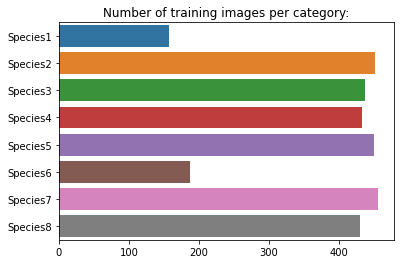

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
og_dataset = './splitted/train'
category_names = sorted(os.listdir(og_dataset))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = og_dataset + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

Printing one image for each class

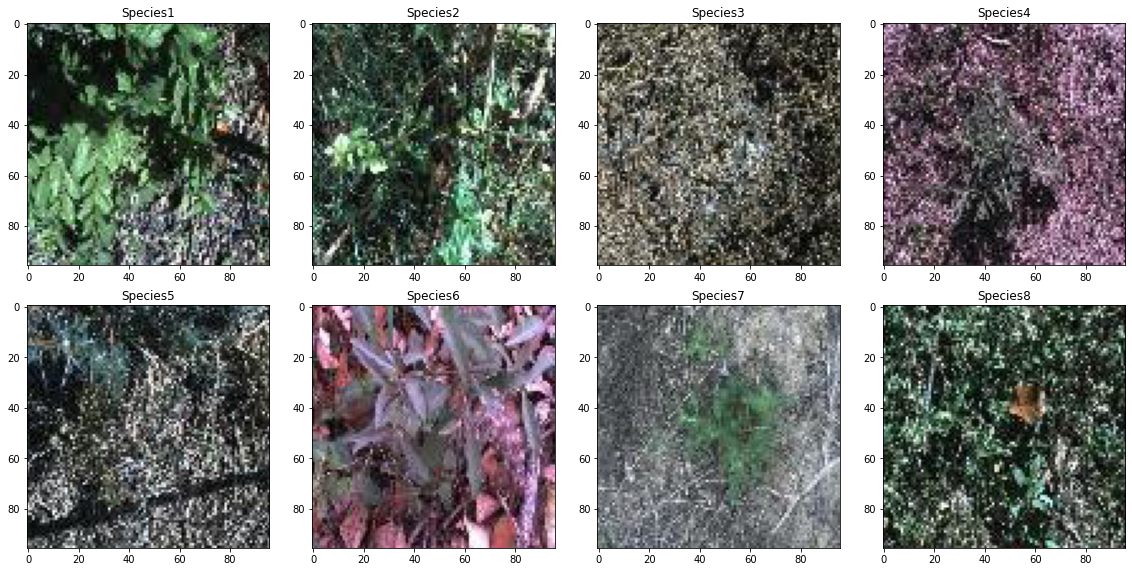

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'val') 

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


#Data augmentation
Adding data augmentation on the training set

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
batch_size = 8

aug_train_data_gen = ImageDataGenerator(rotation_range=10,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        brightness_range=[0.9,1.3],
                                        horizontal_flip=False,
                                        vertical_flip=False, 
                                        fill_mode='reflect',
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        #rescale=1./255
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1./255,
                                    #rotation_range=10,
                                    #height_shift_range=20,
                                    #width_shift_range=20,
                                    #zoom_range=0.5,
                                    #brightness_range=[0.9,1.3],
                                    #horizontal_flip=False,
                                    #vertical_flip=False, 
                                    #fill_mode='reflect',
                                    #cval=0,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1./255,
                                   #rotation_range=180,
                                    #height_shift_range=20,
                                    #width_shift_range=20,
                                    #zoom_range=0.5,
                                    #brightness_range=[0.5,1.5],
                                    #horizontal_flip=True,
                                    #vertical_flip=True, 
                                    #fill_mode='reflect',
                                   preprocessing_function = preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               batch_size=batch_size,
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             batch_size=batch_size,
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=seed)

Found 3007 images belonging to 8 classes.
Found 535 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


#Callbacks
Adding the callbacks at the end of each epoch. We have added just the Early stopping

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  callbacks = []
  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Transfer Learning
Loading the ResNet model with pre-trained weights from Imagenet and adding one dense layer on top of the network

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176

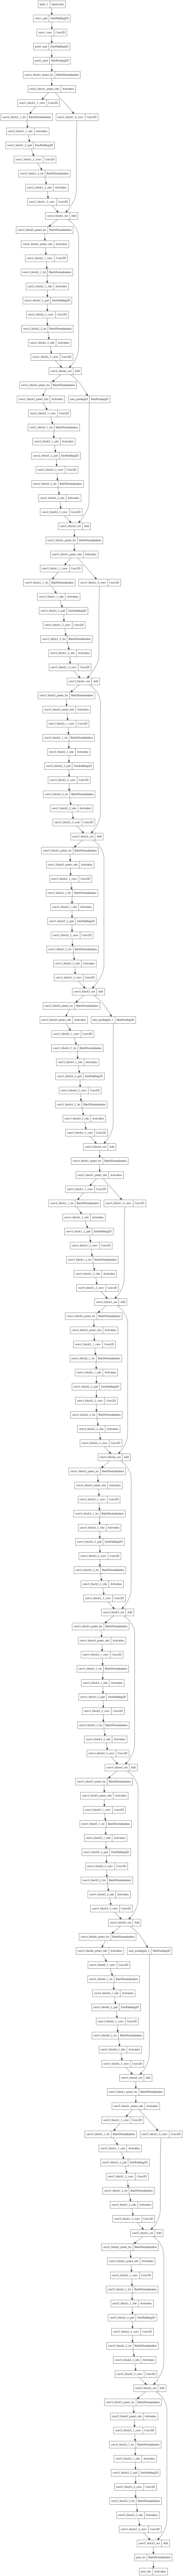

In [ ]:
from tensorflow.keras import regularizers

tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')


base_model = tfk.applications.resnet_v2.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = tf.keras.layers.Resizing( 224, 224, interpolation='bilinear', crop_to_aspect_ratio=True,) (inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    1024, 
    activation='leaky_relu',)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', name='Output')(x)

tl_model = tfk.Model(inputs, output_layer)

tl_model.compile(optimizer=tfk.optimizers.Adam(0.0001),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

tfk.utils.plot_model(base_model)


##Weights
Adding weights in order to balance the classes

In [ ]:
class_weight = {0: 2.8,
                1: 1.,
                2: 1.,
                3: 1.,
                4: 1.,
                5: 2.4,
                6: 1.,
                7: 1.}

Training the model

In [ ]:
# Train the model

tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=tl_callbacks, validation_data=valid_gen, class_weight=class_weight)

Epoch 1/200
376/376 [==============================] - 33s 47ms/step - loss: 1.9902 - accuracy: 0.3841 - precision: 0.5387 - recall: 0.1736 - val_loss: 1.2357 - val_accuracy: 0.5421 - val_precision: 0.7094 - val_recall: 0.3103
Epoch 2/200
376/376 [==============================] - 16s 42ms/step - loss: 1.6160 - accuracy: 0.4992 - precision: 0.6303 - recall: 0.3073 - val_loss: 1.1382 - val_accuracy: 0.5888 - val_precision: 0.7456 - val_recall: 0.3944
Epoch 3/200
376/376 [==============================] - 20s 54ms/step - loss: 1.4573 - accuracy: 0.5431 - precision: 0.6515 - recall: 0.3761 - val_loss: 1.0638 - val_accuracy: 0.6280 - val_precision: 0.7446 - val_recall: 0.4523
Epoch 4/200
376/376 [==============================] - 19s 51ms/step - loss: 1.4491 - accuracy: 0.5527 - precision: 0.6576 - recall: 0.3928 - val_loss: 1.0531 - val_accuracy: 0.6206 - val_precision: 0.7438 - val_recall: 0.4505
Epoch 5/200
376/376 [==============================] - 19s 50ms/step - loss: 1.4206 - accura

#Results
Plotting the results of the training

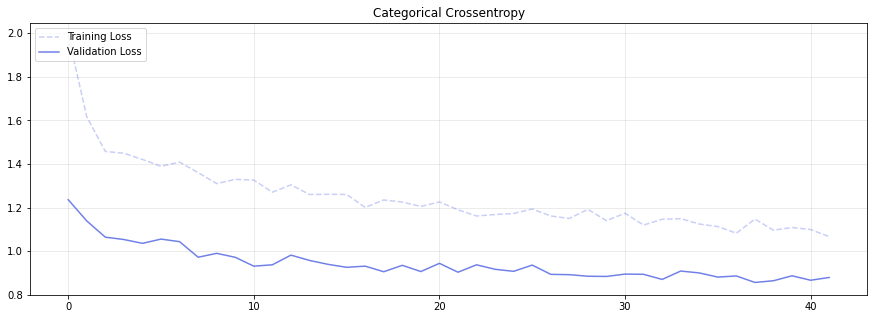

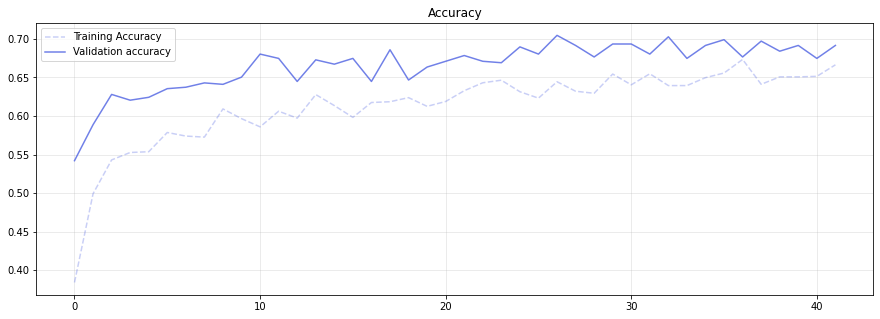

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(tl_history.history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history.history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

##Confusion matrix

67/67 [==============================] - 3s 27ms/step
[0 7 0 0 1 0 6 4 5 0 0 0 0 6 7 0 4 0 7 1 3 3 7 0 0 0 3 0 1 6 1 1 1 6 1 1 7
 1 1 5 1 1 1 1 1 1 1 1 6 1 1 3 1 5 1 1 6 1 0 1 1 1 5 6 6 0 1 1 1 1 6 1 1 6
 1 1 6 6 1 6 1 6 1 1 6 1 2 1 1 6 1 1 0 7 6 1 1 1 6 1 1 1 1 6 1 1 1 1 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 2 2 2 2 2 2 2 4 2 2 2 0 2 2 2 2 2 2
 2 6 1 2 2 2 2 2 2 2 3 2 2 2 2 2 6 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 4 2 2 4
 2 3 3 3 3 3 3 4 2 3 4 3 3 3 3 2 3 3 3 4 2 2 4 3 3 3 3 3 3 3 3 4 3 4 3 3 3
 5 3 3 6 3 1 3 3 3 3 3 4 2 3 7 3 3 3 4 3 3 3 3 2 3 3 3 3 2 6 3 3 3 3 3 4 4
 3 3 3 4 4 2 4 4 6 4 3 4 4 4 3 2 4 4 4 4 4 2 2 4 4 4 4 4 4 4 2 3 2 2 4 4 4
 4 4 4 4 4 4 4 3 2 4 4 4 1 6 3 4 4 3 4 3 4 4 4 4 4 4 4 4 3 3 4 4 2 4 4 4 4
 3 4 4 4 4 4 4 6 2 4 5 5 5 5 5 6 5 1 5 5 5 5 5 3 5 5 5 5 6 5 5 1 5 5 5 5 5
 5 5 5 1 0 6 5 6 1 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 1 6 6 2 7 6 6 6 6 6 1 6 6 2 6 6 4 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 1
 6 6 1 6 6 7 1 6 6 6 6 6 6 6 7 7 7 2 7 7 3 3 7

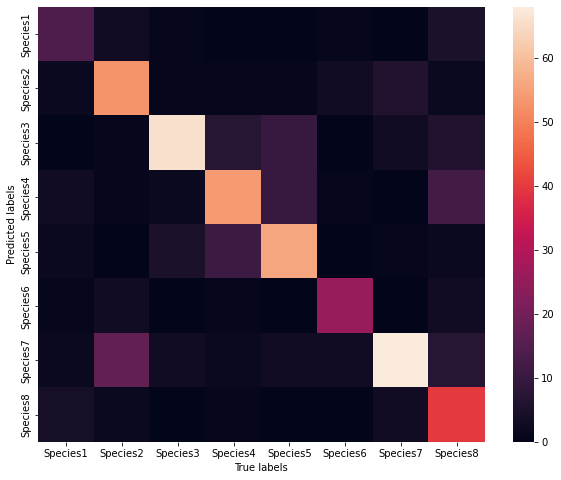

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy for each class

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54        28
           1       0.77      0.66      0.71        80
           2       0.71      0.85      0.77        78
           3       0.65      0.70      0.67        77
           4       0.73      0.70      0.71        80
           5       0.76      0.76      0.76        34
           6       0.65      0.84      0.73        81
           7       0.80      0.52      0.63        77

    accuracy                           0.70       535
   macro avg       0.71      0.69      0.69       535
weighted avg       0.71      0.70      0.70       535



##Saving the best model


In [ ]:
model_dir = '../gdrive/MyDrive/ANNDL/Homework1/models/Franc/ResNet50V2_1024'
tl_model.save(model_dir)

#Fine Tuning
Loading the previously saved model

In [ ]:
ft_model = tfk.models.load_model(model_dir)
ft_model.summary()
ft_model.get_layer('resnet50v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
   print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                             

Retraining the model with all layers unlocked

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

ft_history = ft_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    class_weight=class_weight).history

Epoch 1/200
376/376 [==============================] - 48s 108ms/step - loss: 2.1448 - accuracy: 0.3143 - precision_1: 0.4534 - recall_1: 0.0825 - val_loss: 1.3255 - val_accuracy: 0.4654 - val_precision_1: 0.7374 - val_recall_1: 0.2467
Epoch 2/200
376/376 [==============================] - 39s 104ms/step - loss: 1.7143 - accuracy: 0.4679 - precision_1: 0.6131 - recall_1: 0.2271 - val_loss: 1.2189 - val_accuracy: 0.5103 - val_precision_1: 0.6360 - val_recall_1: 0.2972
Epoch 3/200
376/376 [==============================] - 39s 102ms/step - loss: 1.5485 - accuracy: 0.5205 - precision_1: 0.6648 - recall_1: 0.3206 - val_loss: 1.1406 - val_accuracy: 0.5757 - val_precision_1: 0.7203 - val_recall_1: 0.4187
Epoch 4/200
376/376 [==============================] - 38s 102ms/step - loss: 1.3692 - accuracy: 0.5830 - precision_1: 0.7231 - recall_1: 0.4160 - val_loss: 1.0406 - val_accuracy: 0.6019 - val_precision_1: 0.7490 - val_recall_1: 0.3682
Epoch 5/200
376/376 [==============================] - 3

Save the model

In [ ]:
#Save the best model
ft_model.save(model_dir+'_tuned')

#Results
Viewing the results of the fine tuned model

In [ ]:
ft_test_metrics = ft_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(ft_test_metrics)

67/67 [==============================] - 3s 41ms/step - loss: 0.6196 - accuracy: 0.7888 - precision_1: 0.8160 - recall_1: 0.7626

Test metrics without data augmentation
{'loss': 0.6195659637451172, 'accuracy': 0.7887850403785706, 'precision_1': 0.8159999847412109, 'recall_1': 0.7626168131828308}


67/67 [==============================] - 2s 30ms/step
[0 7 0 0 1 0 6 4 5 0 0 0 0 6 7 0 4 0 7 1 3 3 7 0 0 0 3 0 1 6 1 1 1 6 1 1 7
 1 1 5 1 1 1 1 1 1 1 1 6 1 1 3 1 5 1 1 6 1 0 1 1 1 5 6 6 0 1 1 1 1 6 1 1 6
 1 1 6 6 1 6 1 6 1 1 6 1 2 1 1 6 1 1 0 7 6 1 1 1 6 1 1 1 1 6 1 1 1 1 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 2 2 2 2 2 2 2 4 2 2 2 0 2 2 2 2 2 2
 2 6 1 2 2 2 2 2 2 2 3 2 2 2 2 2 6 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 4 2 2 4
 2 3 3 3 3 3 3 4 2 3 4 3 3 3 3 2 3 3 3 4 2 2 4 3 3 3 3 3 3 3 3 4 3 4 3 3 3
 5 3 3 6 3 1 3 3 3 3 3 4 2 3 7 3 3 3 4 3 3 3 3 2 3 3 3 3 2 6 3 3 3 3 3 4 4
 3 3 3 4 4 2 4 4 6 4 3 4 4 4 3 2 4 4 4 4 4 2 2 4 4 4 4 4 4 4 2 3 2 2 4 4 4
 4 4 4 4 4 4 4 3 2 4 4 4 1 6 3 4 4 3 4 3 4 4 4 4 4 4 4 4 3 3 4 4 2 4 4 4 4
 3 4 4 4 4 4 4 6 2 4 5 5 5 5 5 6 5 1 5 5 5 5 5 3 5 5 5 5 6 5 5 1 5 5 5 5 5
 5 5 5 1 0 6 5 6 1 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 1 6 6 2 7 6 6 6 6 6 1 6 6 2 6 6 4 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 1
 6 6 1 6 6 7 1 6 6 6 6 6 6 6 7 7 7 2 7 7 3 3 7

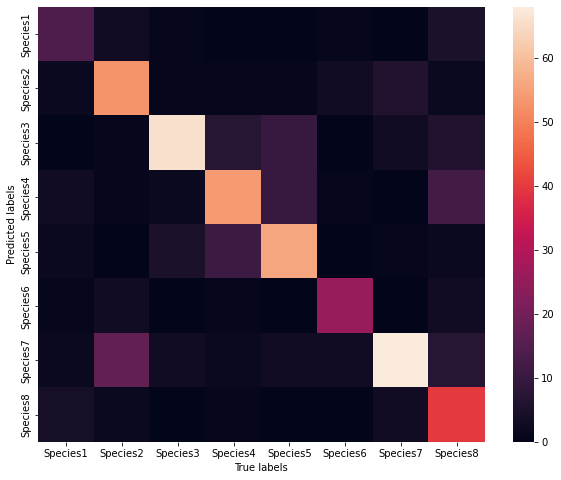

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.58      0.50      0.54        28
           1       0.77      0.66      0.71        80
           2       0.71      0.85      0.77        78
           3       0.65      0.70      0.67        77
           4       0.73      0.70      0.71        80
           5       0.76      0.76      0.76        34
           6       0.65      0.84      0.73        81
           7       0.80      0.52      0.63        77

    accuracy                           0.70       535
   macro avg       0.71      0.69      0.69       535
weighted avg       0.71      0.70      0.70       535

